# 1. Simple CNN (Convolutional Neural Network)


In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import datetime


2024-08-17 17:21:13.757357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 17:21:13.757478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 17:21:13.888856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

# Ensure GPU is available and set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


**DATA**

In [4]:
# Paths to training and validation data
train_path = "/kaggle/input/indian-birds/Birds_25/train"
val_path = "/kaggle/input/indian-birds/Birds_25/valid"


In [5]:
# Parameters
img_height, img_width = 128, 128
batch_size = 32


In [6]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 30000 files belonging to 25 classes.
Found 7500 files belonging to 25 classes.


In [7]:
# Print class names
class_names = train_ds.class_names
print(*class_names)


Asian-Green-Bee-Eater Brown-Headed-Barbet Cattle-Egret Common-Kingfisher Common-Myna Common-Rosefinch Common-Tailorbird Coppersmith-Barbet Forest-Wagtail Gray-Wagtail Hoopoe House-Crow Indian-Grey-Hornbill Indian-Peacock Indian-Pitta Indian-Roller Jungle-Babbler Northern-Lapwing Red-Wattled-Lapwing Ruddy-Shelduck Rufous-Treepie Sarus-Crane White-Breasted-Kingfisher White-Breasted-Waterhen White-Wagtail


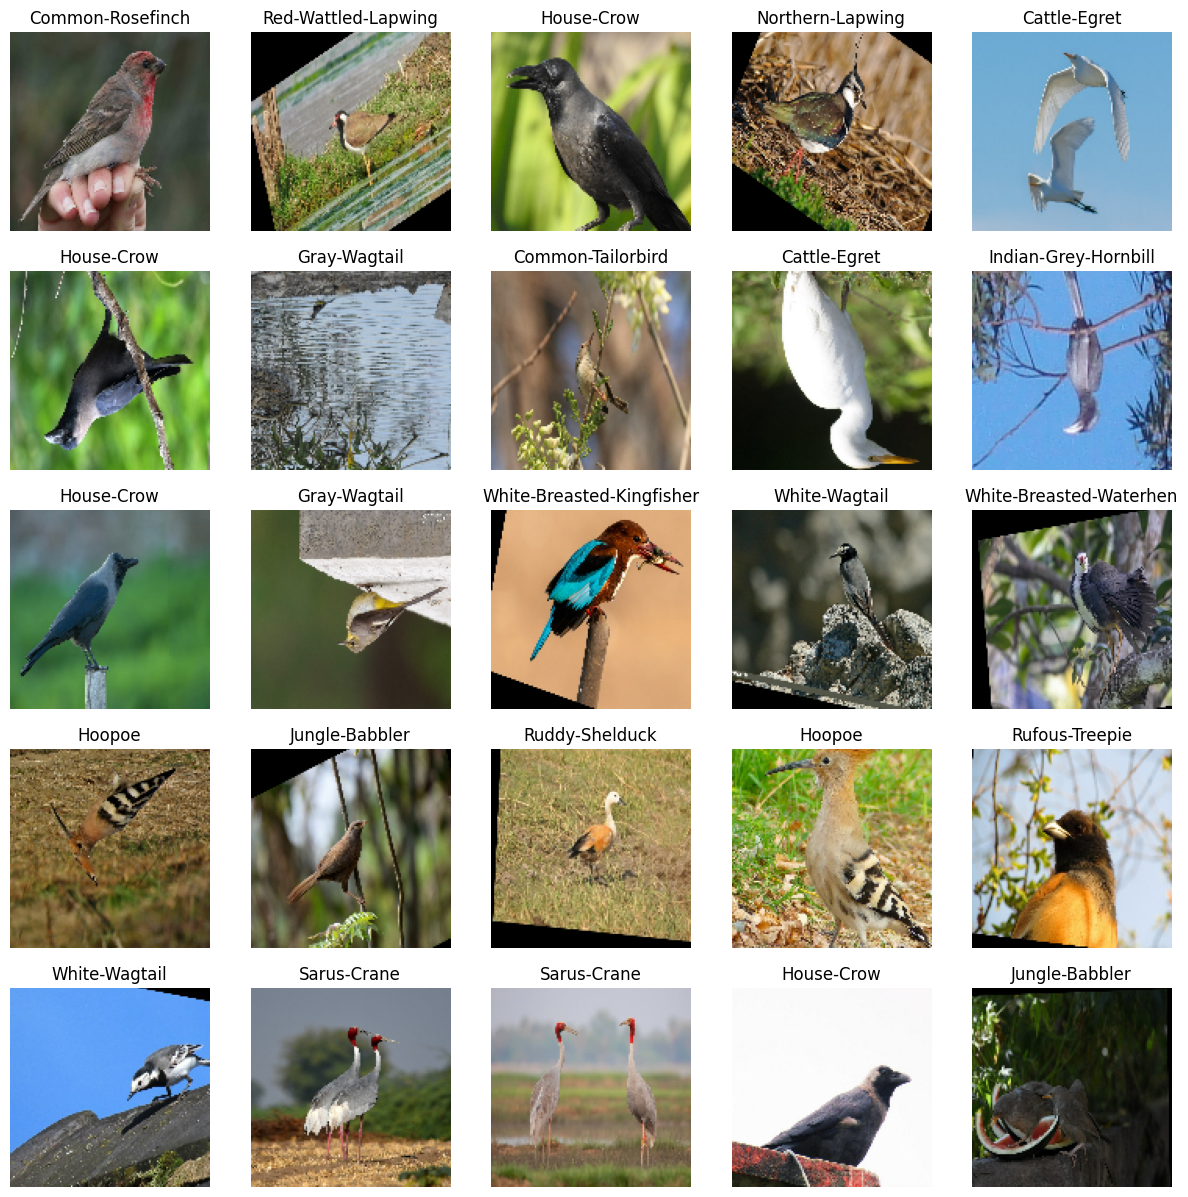

In [8]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training dataset
image_batch, label_batch = next(iter(train_ds))

# Define the number of samples to display
num_samples = 25  # Display 25 images (5x5 grid)
plt.figure(figsize=(15, 15))

for i in range(num_samples):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

plt.show()


In [9]:
# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [10]:
# Preprocess and optimize data loading
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


**Model**

In [11]:
# Define the model
num_classes = len(class_names)

model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),  # Define input shape
    data_augmentation,  # Apply augmentation first
    layers.Rescaling(1./255),  # Then rescale
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes)
])


In [12]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# Model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,124,089 (8.10 MB)

 Trainable params: 2,124,089 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

**Train**

In [14]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [15]:
# TensorBoard callback for visualization
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/checkpoint/checkpoint-{epoch:02d}-{val_loss:.2f}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)


In [17]:
# Train the model
epochs = 150

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, tensorboard_callback,checkpoint_callback]
)


Epoch 1/150


2024-08-17 17:21:41.689917: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.0741 - loss: 3.9547
Epoch 1: val_loss improved from inf to 2.79044, saving model to /kaggle/working/checkpoint/checkpoint-01-2.79.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 123s 126ms/step - accuracy: 0.0742 - loss: 3.9541 - val_accuracy: 0.1451 - val_loss: 2.7904
Epoch 2/150
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1752 - loss: 2.8321
Epoch 2: val_loss improved from 2.79044 to 2.59194, saving model to /kaggle/working/checkpoint/checkpoint-02-2.59.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.1753 - loss: 2.8319 - val_accuracy: 0.2277 - val_loss: 2.5919
Epoch 3/150
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2175 - loss: 2.6981
Epoch 3: val_loss improved from 2.59194 to 2.44730, saving model to /kaggle/working/checkpoint/checkpoint-03-2.45.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.2175 - loss: 2.6980 - val_accuracy: 0.2841 - val_loss: 2.4473
Epoch 4/150
938/938 ━━━━━━━━━━━━

In [18]:
# Save the final model (this will be the best model if early stopping is triggered)
model.save_weights('/kaggle/working/final_model.weights.h5')

In [19]:
# Attempt to save the model in HDF5 format
path ="/kaggle/working/final_model"
try:
    model.save(f'{path}.h5')
    print("Model saved successfully in HDF5 format.")
except Exception as e:
    print(f"Failed to save model in HDF5 format: {e}")
    print("Attempting to save model in Keras format...")
    try:
        model.save(f'{path}.keras')
        print("Model saved successfully in Keras format.")
    except Exception as e:
        print(f"Failed to save model in Keras format: {e}")

Failed to save model in HDF5 format: cannot pickle 'module' object
Attempting to save model in Keras format...
Model saved successfully in Keras format.


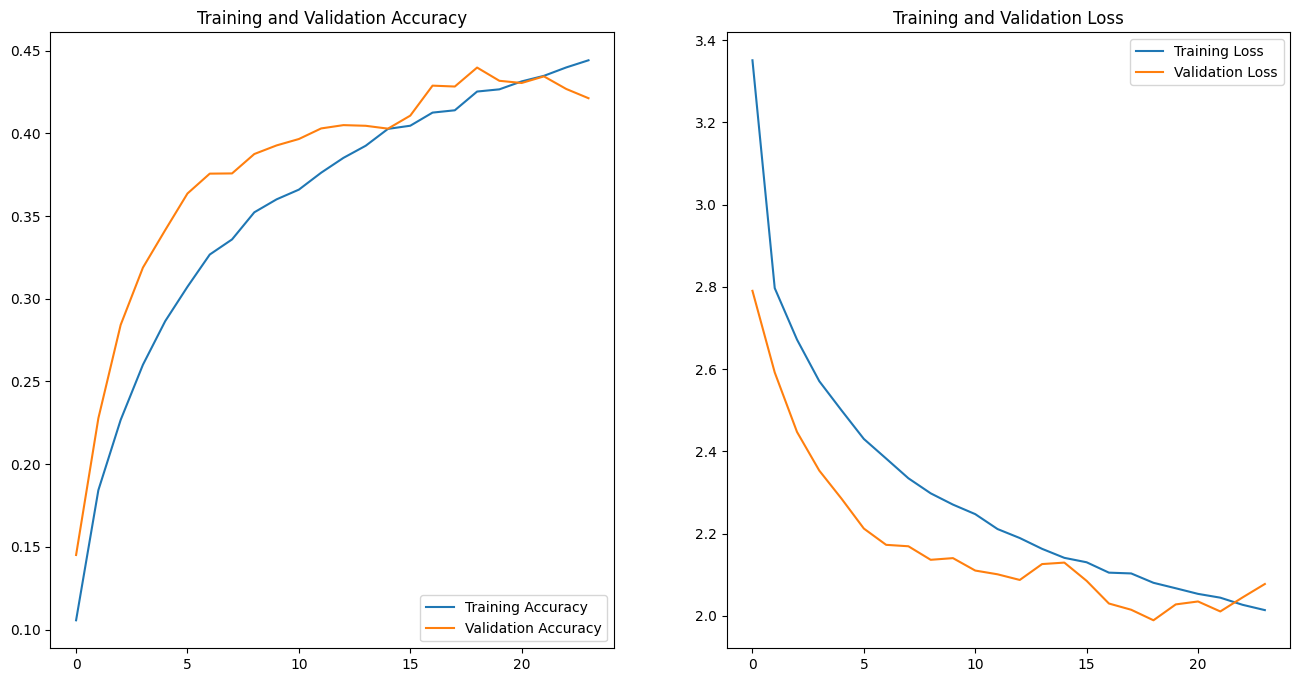

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# Retrieve the number of completed epochs
epochs = len(history.history['accuracy'])

# Define the range for epochs
epochs_range = range(epochs)

# Plot training & validation accuracy and loss
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [21]:
loss, accuracy = model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.2f}')
print(f'Validation loss: {loss:.2f}')


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4455 - loss: 1.9774
Validation Accuracy: 0.44
Validation loss: 1.99


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


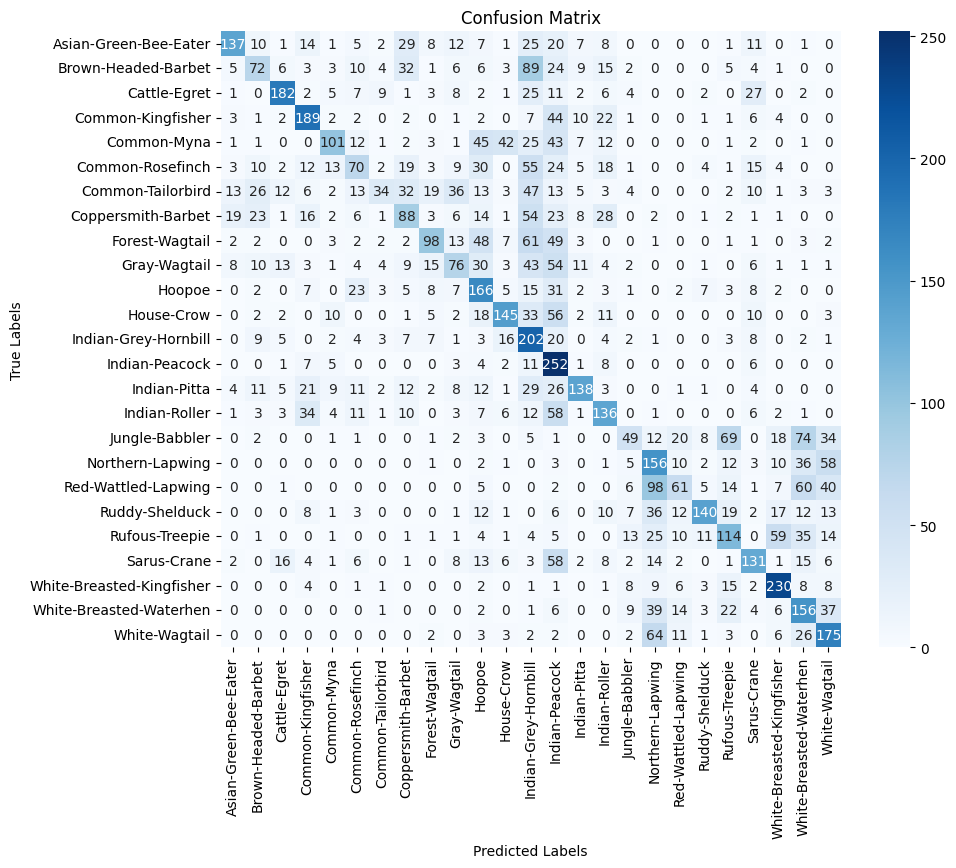

Classification Report:
                            precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.69      0.46      0.55       300
      Brown-Headed-Barbet       0.39      0.24      0.30       300
             Cattle-Egret       0.72      0.61      0.66       300
        Common-Kingfisher       0.57      0.63      0.60       300
              Common-Myna       0.60      0.34      0.43       300
         Common-Rosefinch       0.37      0.23      0.29       300
        Common-Tailorbird       0.49      0.11      0.18       300
       Coppersmith-Barbet       0.35      0.29      0.32       300
           Forest-Wagtail       0.54      0.33      0.41       300
             Gray-Wagtail       0.37      0.25      0.30       300
                   Hoopoe       0.37      0.55      0.44       300
               House-Crow       0.58      0.48      0.53       300
     Indian-Grey-Hornbill       0.27      0.67      0.39       300
           Indian-Peacock       0.30 

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=-1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)
